In [279]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from string import punctuation
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import os
import csv
import pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Rita\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
# prepare corpus
corpus = []
for d in range(1400):
    f = open("C:\\Users\\Rita\\Documents\\cranfild\\"+"./d/"+str(d+1)+".txt")
    corpus.append(f.read())

In [24]:
# prepare queries
queries=[]

path='C:\\Users\\Rita\\Documents\\cranfild\\q\\'
os.chdir(path)
dir_work = os.listdir(path)
a = len (dir_work)

for q in range(0, a):
    f = open(path+str(q+1)+".txt")
    queries.append(f.read())

In [ ]:
#
#preprocessing of documents
#

In [60]:
#tokenization of documents
doc_tokens=[nltk.word_tokenize(sent) for sent in corpus]

#delete punct
nopunc_doc=[]
for token in doc_tokens:
    temp=[]
    for t in token:
        if t not in punctuation:
            temp.append(t)
    nopunc_doc.append(temp)

# delete stop-words
st_words_doc=[]
stops = stopwords.words('english')

for token in nopunc_doc:
    temp=[]
    for t in token:
        if t not in stops:
            temp.append(t)
    st_words_doc.append(temp)    

#stemming
stemmer = PorterStemmer()
stems_d=[]

for token in st_words_doc:
    temp1=[]
    for t in token:
        temp1.append(stemmer.stem(t))
    stems_d.append(temp1)

In [ ]:
#
#preprocessing queries
#

In [35]:
#tokenization of queries
q_tokens=[nltk.word_tokenize(sent) for sent in queries]

#delete punct & stops
nopunc_st_q=[]
for token in q_tokens:
    temp=[]
    for t in token:
        if (t not in punctuation) & (t not in stops):
            temp.append(t)
    nopunc_st_q.append(temp)

#stemming
stems_q=[]

for token in nopunc_st_q:
    temp1=[]
    for t in token:
        temp1.append(stemmer.stem(t))
    stems_q.append(temp1)

In [ ]:
#
#preprocessing of corpus
#

In [57]:
#tokenization
corp_t=[nltk.word_tokenize(sent) for sent in corpus]

corpus_all=[]
for token in corp_t:
    for t in token:
        if t not in corpus_all:
            corpus_all.append(t)

#delete punct
corp_nopunc_st=[]
for token in corpus_all:
    if (token not in punctuation) & (token not in stops):
        corp_nopunc_st.append(token) 

#stemming
stems_corp=[stemmer.stem(t) for t in corp_nopunc_st]

In [63]:
#binarization + term freq of documents
binary_doc=np.zeros([len(stems_d), len(stems_corp)])
freq_doc=np.zeros([len(stems_d), len(stems_corp)])

for i in range(0, len(stems_d)):
    for j in range(0, len(stems_d[i])):
        if stems_d[i][j] in stems_corp:
            idx=stems_corp.index(stems_d[i][j])
            binary_doc[i, idx]=1
            freq_doc[i, idx]+=1
    if len(stems_d[i])==0:
        print('aaa')
    else:
        freq_doc[i, :]= freq_doc[i, :]/len(stems_d[i])

aaa
aaa


In [64]:
#binarization + term freq of queries
binary_q=np.zeros([len(stems_q), len(stems_corp)])
freq_q=np.zeros([len(stems_q), len(stems_corp)])

for i in range(0, len(stems_q)):
    for j in range(0, len(stems_q[i])):
        if stems_q[i][j] in stems_corp:
            idx=stems_corp.index(stems_q[i][j])
            binary_q[i, idx]=1
            freq_q[i, idx]+=1
    if len(stems_q[i])==0:
        continue
    else:   
        freq_q[i, :]= freq_q[i, :]/len(stems_q[i])

In [70]:
#TF-IDF
tfidf_vectorizer = TfidfVectorizer()
 
# prepare matrix docs+queries
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
tfidf_matrix_q = tfidf_vectorizer.transform(queries)

In [71]:
#
# preparing ground truth
#

In [268]:
#read files
ground_truth=[]

path='C:\\Users\\Rita\\Documents\\cranfild\\r\\'
os.chdir(path)
dir_work = os.listdir(path)
a = len (dir_work)

for r in range(0, a):
    f = open(path+str(r+1)+".txt")
    temp=f.read()
    st=temp.split('\n')
    stt=[]
    for s in st:
        if s!='':
            stt.append(int(s))
    ground_truth.append(stt)

In [200]:
#distance measure

def euc_distance_measure(docs, sample):
    euc_d = np.array(euclidean_distances(docs, sample))
    top_eu=(np.argsort(euc_d, axis=0))+1
    top_eu = np.array(list(map(int, top_eu)))
    return top_eu[-10:].transpose()

In [201]:
#cosine distance measure

def cos_distance_measure(docs, sample):
    cos_d=np.array(cosine_similarity(docs, sample))
    top_cos=(np.argsort(cos_d, axis=0))+1
    top_cos = np.array(list(map(int, top_cos)))
    return top_cos[-10:].transpose()

In [128]:
#recall score

def recall_score_(ground_truth, predicted):
    tp=set(ground_truth).intersection(predicted)
    fp=set(predicted)-set(ground_truth)
    fn=set(ground_truth)-set(predicted)
    sc=len(tp)/(len(tp)+len(fn))
    return sc

In [129]:
#precision score

def precision_score_(ground_truth, predicted):
    tp=set(ground_truth).intersection(predicted)
    fp=set(predicted)-set(ground_truth)
    fn=set(ground_truth)-set(predicted)
    sc=len(tp)/(len(tp)+len(fp))
    return sc

In [269]:
#metrics measure

def metrics_measure(predicted, ground_truth):
    pres=precision_score_(ground_truth, predicted)
    rec=recall_score_(ground_truth, predicted)
    if (pres==0) & (rec==0):
        f1=0
    else:
        f1=2*pres*rec/(pres+rec)
    return pres, rec, f1                     

In [270]:
#running calculating relevance scores and metrics, 0 - cos, 1 - euc
#0 - precision, 1 - recall, 2 - f1
#for binary

scores_matrix_b_euc=np.zeros([len(queries), 10])
scores_matrix_b_cos=np.zeros([len(queries), 10])
metrics_matrix_b_euc=np.zeros([len(queries), 3])
metrics_matrix_b_cos=np.zeros([len(queries), 3])

for i in range(0, len(queries)):
    scores_matrix_b_euc[i, :] = euc_distance_measure(binary_doc, binary_q[i,:].reshape(1,-1))
    scores_matrix_b_cos[i, :] = cos_distance_measure(binary_doc, binary_q[i, :].reshape(1,-1))
    
    metrics_matrix_b_euc[i, 0], metrics_matrix_b_euc[i, 1], metrics_matrix_b_euc[i, 2] = metrics_measure(scores_matrix_b_euc[i, :], ground_truth[i])
    metrics_matrix_b_cos[i, 0], metrics_matrix_b_cos[i, 1], metrics_matrix_b_cos[i, 2] = metrics_measure(scores_matrix_b_cos[i, :], ground_truth[i])
    

In [271]:
#running calculating relevance scores and metrics, 0 - cos, 1 - euc
#0 - precision, 1 - recall, 2 - f1
#for freq

scores_matrix_f_euc=np.zeros([len(queries), 10])
scores_matrix_f_cos=np.zeros([len(queries), 10])
metrics_matrix_f_euc=np.zeros([len(queries), 3])
metrics_matrix_f_cos=np.zeros([len(queries), 3])

for i in range(0, len(queries)):
    scores_matrix_f_euc[i, :] = euc_distance_measure(freq_doc, freq_q[i,:].reshape(1,-1))
    scores_matrix_f_cos[i, :] = cos_distance_measure(freq_doc, freq_q[i, :].reshape(1,-1))
    
    metrics_matrix_f_euc[i, 0], metrics_matrix_f_euc[i, 1], metrics_matrix_f_euc[i, 2] = metrics_measure(scores_matrix_f_euc[i, :], ground_truth[i])
    metrics_matrix_f_cos[i, 0], metrics_matrix_f_cos[i, 1], metrics_matrix_f_cos[i, 2] = metrics_measure(scores_matrix_f_cos[i, :], ground_truth[i])

In [272]:
#running calculating relevance scores and metrics, 0 - cos, 1 - euc
#0 - precision, 1 - recall, 2 - f1
#for tf-idf

scores_matrix_tf_euc=np.zeros([len(queries), 10])
scores_matrix_tf_cos=np.zeros([len(queries), 10])
metrics_matrix_tf_euc=np.zeros([len(queries), 3])
metrics_matrix_tf_cos=np.zeros([len(queries), 3])

for i in range(0, len(queries)):
    scores_matrix_tf_euc[i, :] = euc_distance_measure(tfidf_matrix,  tfidf_matrix_q[i])
    scores_matrix_tf_cos[i, :] = cos_distance_measure(tfidf_matrix,  tfidf_matrix_q[i])
    
    metrics_matrix_tf_euc[i, 0], metrics_matrix_tf_euc[i, 1], metrics_matrix_tf_euc[i, 2] = metrics_measure(scores_matrix_tf_euc[i, :], ground_truth[i])
    metrics_matrix_tf_cos[i, 0], metrics_matrix_tf_cos[i, 1], metrics_matrix_tf_cos[i, 2] = metrics_measure(scores_matrix_tf_cos[i, :], ground_truth[i])

In [220]:
#
#visualization
#

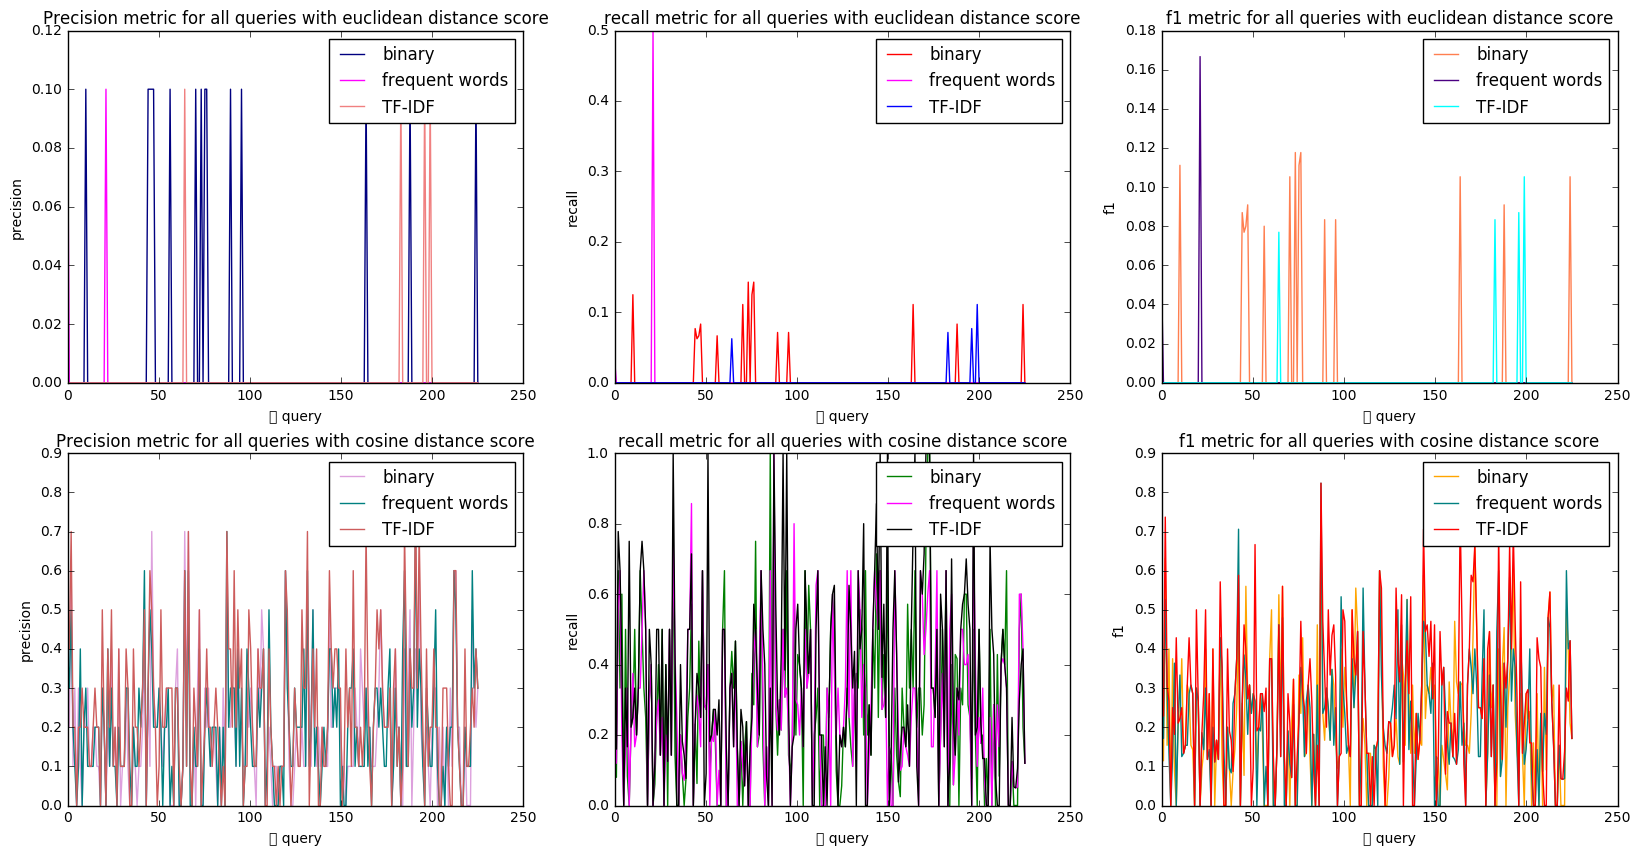

In [277]:
fig=plt.figure(figsize = (20, 10))

a1=fig.add_subplot(2,3,1)
plt.title('Precision metric for all queries with euclidean distance score')
a,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_b_euc[:, 0], color='navy', label='binary')
b,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_f_euc[:, 0], color='magenta', label='frequent words')
c,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_tf_euc[:, 0], color='lightcoral', label='TF-IDF')
plt.xlabel('№ query')
plt.ylabel('precision')
plt.legend(handles=[a, b, c], loc=1)

a2=fig.add_subplot(2,3,2)
plt.title('recall metric for all queries with euclidean distance score')
d,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_b_euc[:, 1], color='red', label='binary')
e,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_f_euc[:, 1], color='magenta', label='frequent words')
f,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_tf_euc[:, 1], color='blue', label='TF-IDF')
plt.xlabel('№ query')
plt.ylabel('recall')
plt.legend(handles=[d, e, f], loc=1)

a3=fig.add_subplot(2,3,3)
plt.title('f1 metric for all queries with euclidean distance score')
g,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_b_euc[:, 2], color='coral', label='binary')
h,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_f_euc[:, 2], color='indigo', label='frequent words')
i,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_tf_euc[:, 2], color='cyan', label='TF-IDF')
plt.xlabel('№ query')
plt.ylabel('f1')
plt.legend(handles=[g, h, i], loc=1)

a4=fig.add_subplot(2,3,4)
plt.title('Precision metric for all queries with cosine distance score')
j,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_b_cos[:, 0], color='plum', label='binary')
k,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_f_cos[:, 0], color='teal', label='frequent words')
l,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_tf_cos[:, 0], color='indianred', label='TF-IDF')
plt.xlabel('№ query')
plt.ylabel('precision')
plt.legend(handles=[j, k, l], loc=1)

a5=fig.add_subplot(2,3,5)
plt.title('recall metric for all queries with cosine distance score')
m,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_b_cos[:, 1], color='green', label='binary')
n,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_f_cos[:, 1], color='magenta', label='frequent words')
o,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_tf_cos[:, 1], color='black', label='TF-IDF')
plt.xlabel('№ query')
plt.ylabel('recall')
plt.legend(handles=[m, n, o], loc=1)

a6=fig.add_subplot(2,3,6)
plt.title('f1 metric for all queries with cosine distance score')
p,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_b_cos[:, 2], color='orange', label='binary')
q,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_f_cos[:, 2], color='teal', label='frequent words')
r,=plt.plot(linspace(0,len(queries),len(queries)),metrics_matrix_tf_cos[:, 2], color='red', label='TF-IDF')
plt.xlabel('№ query')
plt.ylabel('f1')
plt.legend(handles=[p, q, r], loc=1)

In [281]:
pickle.dump(metrics_matrix_b_euc, open( "metrics_euc_bin.p", "wb" ) )
pickle.dump(metrics_matrix_f_euc, open( "metrics_euc_f.p", "wb" ) )
pickle.dump(metrics_matrix_tf_euc, open( "metrics_euc_tf.p", "wb" ) )
pickle.dump(metrics_matrix_b_cos, open( "metrics_cos_bin.p", "wb" ) )
pickle.dump(metrics_matrix_f_cos, open( "metrics_cos_f.p", "wb" ) )
pickle.dump(metrics_matrix_tf_cos, open( "metrics_cos_tf.p", "wb" ) )